In [158]:
# Data processing
# ==============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
import optuna
import statistics
import json
import copy
import tabulate
import preprocessor as p
import pickle
import requests

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import networkx as nx
from wordcloud import WordCloud
from PIL import Image

# Modelling
# ==============================================================================
import pykeen
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.models.predict import get_tail_prediction_df
from scipy import spatial
from sent2vec.vectorizer import Vectorizer
from LeXmo import LeXmo
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk import tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Configuration
# ==============================================================================
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # print all output in the middle
#pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')
#%config Completer.use_jedi = False

In [159]:
def age_group(age):
    if age[-1] == '+' or age =='NO AGE':
        return age
    else:
        return age[0] + '+'
def age_segment(age):
    if age[0].isdigit():
        age_num = int(age[0])
        for ele in age[1:]:
            if ele.isdigit():
                age_num = age_num*10 + int(ele)
            else:
                break
        if age_num < 4:
            age_segment = '0+'
        elif age_num < 6:
            age_segment = '3+'
        elif age_num < 12:
            age_segment = '6+'
        elif age_num < 16:
            age_segment = '12+'
        elif age_num < 18:
            age_segment = '16+'
        else:
            age_segment = '18+'
    else:
        age_segment = age
    return age_segment

In [160]:
df_specs = pd.read_csv('../../../4Keywords/data/df_specs.csv')
df_specs['age_segment'] = df_specs.ageRange.map(age_segment)
df_specs_running = df_specs[['Item#','theme','pieceCount','Price','age_segment']].drop_duplicates() #df[['link','Theme',,,'price']] = 

In [161]:
df.comment[0]

'This has certainly kept me entertained whilst in lockdown. I done a bag each day, they’re 5 bags in total, I’m a novice at Lego, so found some parts frustrating and made several mistakes, so pay close attention to the instructions, in particular the green half triage pieces, as towards the end run out of ones going a certain direction and had to rebuild a segment! \r\nAll in all it’s been fun to build and love the end result. Great details in the torch, book and really love the balcony section.'

In [172]:
def convert(a):
    if a==4 or a==5:
        return 'POS'
    elif a==3:
        return 'NEU'
    else:
        return 'NEG'

In [173]:
df = pd.read_csv('../../../4Keywords/data/lego_review_df.csv')
df_review = pd.read_csv('../../../4Keywords/data/lego_review_df_sentiment.csv')
df[['processed_comment','sentiment']] = df_review[['comment','sentiment']]
df = df[df.comment.notnull()]
df['BERT_SentLabel'] = df['sentiment'].map(convert)
df = pd.merge(left=df, right=df_specs_running, how='left', left_on='product_code', right_on='Item#')

In [216]:
allTriple = pd.read_csv("allTriple0_5200.csv")
allTriple

,target,opinion,sentiment,reviewID,item
0,features,a lot,POS,2807,Skate Park
1,torch,a lot better,NEG,214,New York City
2,length,a lot better,NEG,3365,Pirate Ship
3,detail,a lot more,NEG,3392,Pirate Ship
4,playtime,a lot more,POS,3660,Supersonic-jet
...,...,...,...,...,...
25938,flywheel,TRUE,POS,2758,Rocket Stunt Bike
25939,quality,TRUE,POS,2758,Rocket Stunt Bike
25940,set,TRUE,POS,3927,Colosseum
25941,geometry,TRUE,POS,4786,NASA Space Shuttle Discovery


In [175]:
allTriple[allTriple.item.isin(selected_products)].sentiment.value_counts(normalize=True)[0]

0.5988805970149254

In [176]:
with open("../../../4Keywords/rawSentences/Xlist", "rb") as fp:
    X = pickle.load(fp)    

In [177]:
n_triple = allTriple.reviewID.value_counts()
df['tripleCount'] = 0; 
df.iloc[n_triple.index, df.shape[1]-1] = n_triple
reviewCount = pd.DataFrame(df.groupby(['product_code']).set_name.count()).reset_index()
df = pd.merge(left=df, right=reviewCount, how='left', left_on='product_code', right_on='product_code')
df['sentenceCount'] = [len(l) for l in X]
df['wordsCount'] = df['comment'].str.findall(r'(\w+)').str.len()
df['charCount'] = df['comment'].str.len()
df.head()

,product_code,set_name_x,overallRating,valueForMoney,overallPlayExperience,wouldRecommendPercent,title,comment,processed_comment,sentiment,...,Item#,theme,pieceCount,Price,age_segment,tripleCount,set_name_y,sentenceCount,wordsCount,charCount
0,21042,Statue of Liberty,4.680556,4.369427,3.89313,96.0,Statue of Liberty,This has certainly kept me entertained whilst ...,certainly kept entertained whilst lockdown. do...,4,...,21042,architecture,1685,119.99,16+,4,104,4,94,497
1,21042,Statue of Liberty,4.680556,4.369427,3.89313,96.0,Great Challenging Build,Got this as a bday gift - It´s a highly detail...,got bday gift - it´s highly detailed statue co...,4,...,21042,architecture,1685,119.99,16+,4,104,2,43,236
2,21042,Statue of Liberty,4.680556,4.369427,3.89313,96.0,The Most Patriotic Set from Architecture so far!,The LEGO Architecture Statue of Liberty will c...,lego architecture statue liberty catch eye hou...,4,...,21042,architecture,1685,119.99,16+,9,104,8,184,978
3,21042,Statue of Liberty,4.680556,4.369427,3.89313,96.0,Lady liberty at her finest,As Architecture sets go this one really is a t...,architecture sets go one really true testament...,5,...,21042,architecture,1685,119.99,16+,15,104,8,169,868
4,21042,Statue of Liberty,4.680556,4.369427,3.89313,96.0,"It looks really nice, a great display piece",I saw this was available and felt it would mak...,saw available felt would make great addition g...,3,...,21042,architecture,1685,119.99,16+,3,104,4,75,394


In [178]:
df = df.rename(columns = {'set_name_y':'reviewCount', 'set_name_x':'set_name'})

In [179]:
df_running = df.sort_values(by=['reviewCount','product_code','charCount'], ascending=[False, False, True])

In [180]:
df_running.to_csv('df_running.csv', index = False)

### Fix allTriple

In [217]:
m = pd.concat([pd.DataFrame(sorted(allTriple[allTriple.sentiment=='POS'].opinion.unique())),
           pd.DataFrame(sorted(allTriple[allTriple.sentiment=='NEU'].opinion.unique())),
           pd.DataFrame(sorted(allTriple[allTriple.sentiment=='NEG'].opinion.unique()))], axis = 1)

In [218]:
m.to_csv('m.csv',index=False)

### word cloud on keywords

In [260]:
all_keywords = [k for k in allTriple.target]#.extend([k for k in allTriple.opinion])
pos_keywords = [k for k in allTriple[allTriple.sentiment=='POS'].target]#.extend([k for k in allTriple[allTriple.sentiment=='POS'].opinion])
neg_keywords = [k for k in allTriple[allTriple.sentiment=='NEG'].target]#.extend([k for k in allTriple[allTriple.sentiment=='NEG'].opinion])
neu_keywords = [k for k in allTriple[allTriple.sentiment=='NEU'].target]#.extend([k for k in allTriple[allTriple.sentiment=='NEU'].opinion])
stop_words = ["Lego", "Legos", "set", "sets", "build", "building", "built", "piece", "pieces", "batman"] + list(STOPWORDS)

In [234]:
# positive reviews
from wordcloud import WordCloud
from PIL import Image
cm = ' '.join(list(map(str, pos_keywords)))
mask = np.array(Image.open('upvote.png'))
wcP = WordCloud(stopwords = stop_words, width = 3000, height = 2000, random_state=1, collocations=False, background_color="white", colormap='rainbow', mask=mask).generate(cm)

In [235]:
# negative reviews
from wordcloud import WordCloud
cm = ' '.join(list(map(str, neg_keywords)))
mask = np.array(Image.open('downvote.png'))
wc = WordCloud(stopwords = stop_words, width = 3000, height = 2000, random_state=1, collocations=False, background_color="white", mask=mask).generate(cm)

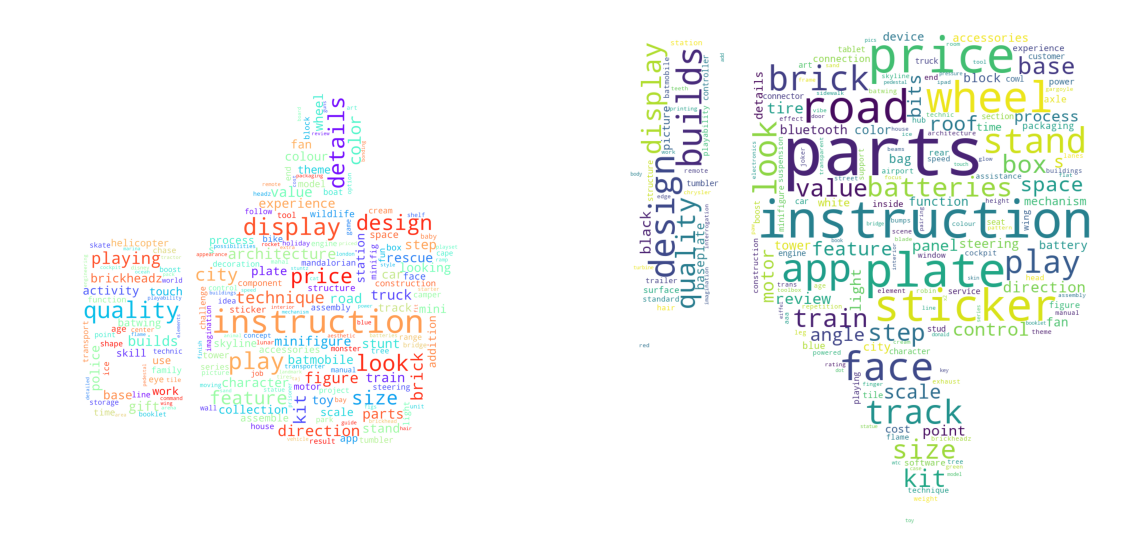

In [236]:
_, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
#plt.figure(figsize = (10, 10))
axs[0].imshow(wcP)
axs[0].axis('off')
#plt.figure(figsize = (8, 8))
axs[1].imshow(wc)
axs[1].axis('off');
plt.savefig('wc.png', dpi = 1200, bbox_inches='tight');

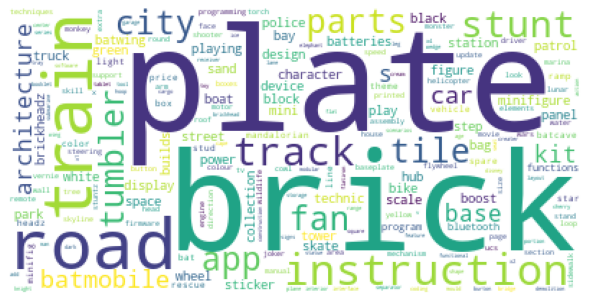

In [256]:
# neutral reviews
from wordcloud import WordCloud
cm = ' '.join(list(map(str, neu_keywords)))
wc = WordCloud(stopwords = stop_words, collocations=False, background_color="white").generate(cm)
plt.figure(figsize = (8, 8))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.savefig('nt.png', dpi = 1200, bbox_inches='tight');

### word cloud on keywords

In [9]:
all_keywords = [k for k in allTriple.target]#.extend([k for k in allTriple.opinion])
pos_keywords = [k for k in allTriple[allTriple.sentiment=='POS'].target]#.extend([k for k in allTriple[allTriple.sentiment=='POS'].opinion])
neg_keywords = [k for k in allTriple[allTriple.sentiment=='NEG'].target]#.extend([k for k in allTriple[allTriple.sentiment=='NEG'].opinion])
neu_keywords = [k for k in allTriple[allTriple.sentiment=='NEU'].target]#.extend([k for k in allTriple[allTriple.sentiment=='NEU'].opinion])
stop_words = ["Lego", "Legos", "set", "sets", "build", "building", "built", "piece", "pieces", "batman"] + list(STOPWORDS)

In [11]:
# positive reviews
cm = ' '.join(list(map(str, pos_keywords)))
mask = np.array(Image.open('upvote.png'))
wcP = WordCloud(stopwords = stop_words, width = 3000, height = 2000, random_state=1, collocations=False, background_color="white", colormap='rainbow', mask=mask).generate(cm)

In [12]:
# negative reviews
cm = ' '.join(list(map(str, neg_keywords)))
mask = np.array(Image.open('downvote.png'))
wc = WordCloud(stopwords = stop_words, width = 3000, height = 2000, random_state=1, collocations=False, background_color="white", mask=mask).generate(cm)

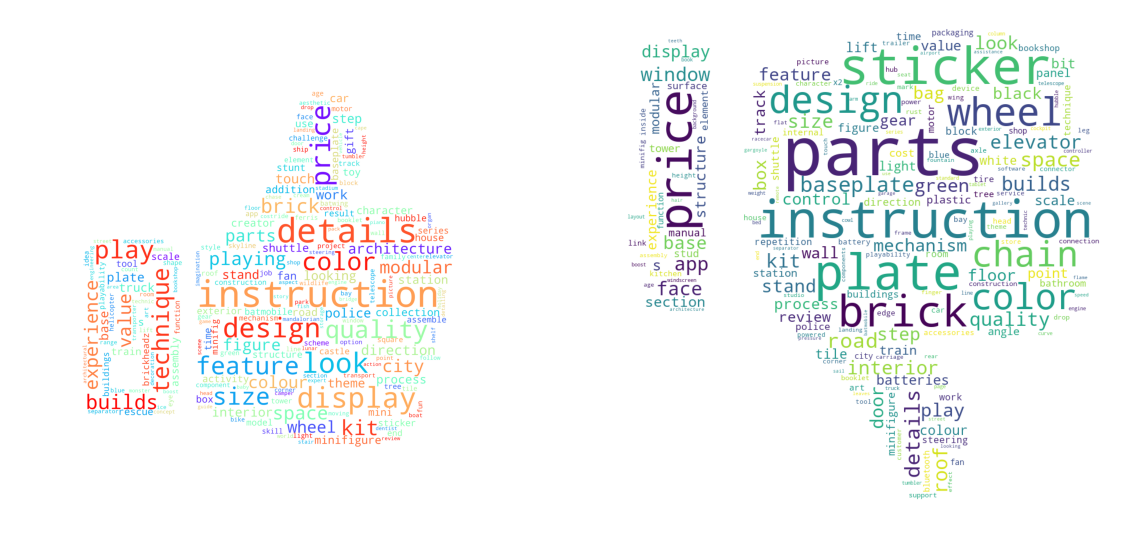

In [13]:
_, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
#plt.figure(figsize = (10, 10))
axs[0].imshow(wcP)
axs[0].axis('off')
#plt.figure(figsize = (8, 8))
axs[1].imshow(wc)
axs[1].axis('off');
plt.savefig('wc.png', dpi = 1200, bbox_inches='tight');

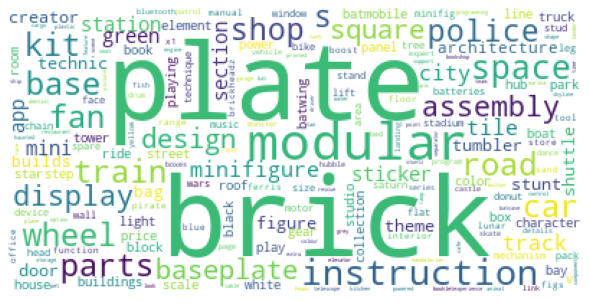

In [14]:
# neutral reviews
cm = ' '.join(list(map(str, neu_keywords)))
wc = WordCloud(stopwords = stop_words, collocations=False, background_color="white").generate(cm)
plt.figure(figsize = (8, 8))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.savefig('nt.png', dpi = 1200, bbox_inches='tight');